In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# agrmax(target) = 2
def target(x):
    return 3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1) +torch.randn(x.size()) * .1

# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function with Gaussian noise N(0,0.01)
train_y = Variable(target(train_x))

#true target (unknown)
x = Variable(torch.linspace(-5, 15, 1000))
y = Variable(target(x))

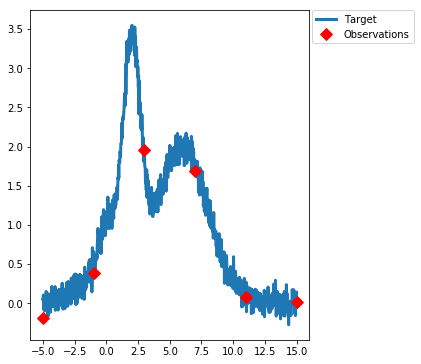

In [3]:
# plotting gp 
def plot_gp(train_x, train_y, x, y, rand_var=None, model=False, acq = None, bo=False):
    fig = plt.figure(figsize=(5,10))
    gs = gridspec.GridSpec(2,1,height_ratios=[2, 1]) 
    axis = plt.subplot(gs[0])
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(train_x, train_y, 'D', markersize=8, label=u'Observations', color='r')
    
    # if model is trained 
    if model == True:
        lower, upper = rand_var.confidence_region()
        mean = rand_var.mean().data.numpy()
        var = rand_var.var().data.numpy()
        axis.plot(x, mean, '--', color='k', label='Prediction')
       # axis.fill_between(x, lower.data.numpy(), upper.data.numpy(), alpha=.6, label='95% confidence interval')
        axis.fill_between(x, y - 1.96 * var , y + 1.96 * var, alpha=.3, label='95% confidence interval')
    
    # if acqusition function is available
    if bo == True:
        acqusition = plt.subplot(gs[1])
        acqusition.plot(x, acq.data.numpy(), label='Utility Function', color='purple')
        acqusition.plot(x[torch.argmax(acq)], torch.max(acq).data.numpy(), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
        acqusition.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
# target function and observations 
plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy())

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return model output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [5]:
# train model to get the hypeparameters 
def train_model(model,train_x,train_y):   
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 10
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.data[0],
            model.covar_module.log_lengthscale.data[0, 0],
            model.likelihood.log_noise.data[0]
        ))
        optimizer.step()


In [6]:
# predict
def eval_model(model,likelihood):   
    # Put model and likelihood into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with gpytorch.fast_pred_var():
        observed_pred = likelihood(model(x))
    return observed_pred

In [7]:
#acquisition function using upper confidence bound 
def ucb(observed_pred, kappa=5):
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    acq = mean + kappa * std
    return acq,torch.argmax(acq)

In [8]:
# expected improvement 
def ei(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = (mean - y_max) * Normal(0,1).cdf(z) + std * Normal(0,1).log_prob(z).exp()
    return acq, torch.argmax(acq)

In [9]:
# probability of improvement
def poi(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = Normal(0,1).cdf(z) 
    return acq, torch.argmax(acq)

Iter 1/10 - Loss: 1.665   log_lengthscale: 0.000   log_noise: -1.000
Iter 2/10 - Loss: 1.639   log_lengthscale: 0.100   log_noise: -1.100
Iter 3/10 - Loss: 1.622   log_lengthscale: 0.200   log_noise: -1.200
Iter 4/10 - Loss: 1.613   log_lengthscale: 0.287   log_noise: -1.300
Iter 5/10 - Loss: 1.613   log_lengthscale: 0.375   log_noise: -1.400
Iter 6/10 - Loss: 1.616   log_lengthscale: 0.465   log_noise: -1.501
Iter 7/10 - Loss: 1.628   log_lengthscale: 0.558   log_noise: -1.602
Iter 8/10 - Loss: 1.654   log_lengthscale: 0.647   log_noise: -1.703
Iter 9/10 - Loss: 1.650   log_lengthscale: 0.728   log_noise: -1.805
Iter 10/10 - Loss: 1.697   log_lengthscale: 0.799   log_noise: -1.905
Iter 1/10 - Loss: 1.664   log_lengthscale: 0.000   log_noise: -1.000
Iter 2/10 - Loss: 1.617   log_lengthscale: 0.100   log_noise: -1.100
Iter 3/10 - Loss: 1.552   log_lengthscale: 0.200   log_noise: -1.200
Iter 4/10 - Loss: 1.562   log_lengthscale: 0.298   log_noise: -1.300
Iter 5/10 - Loss: 1.504   log_len

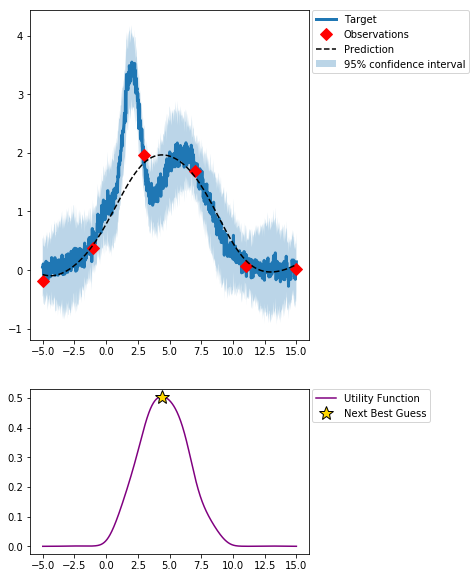

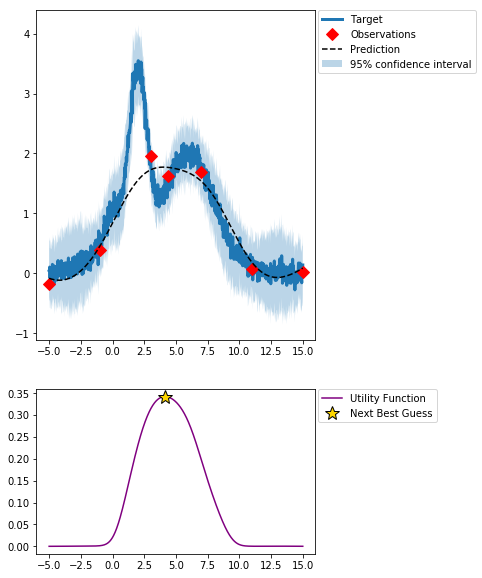

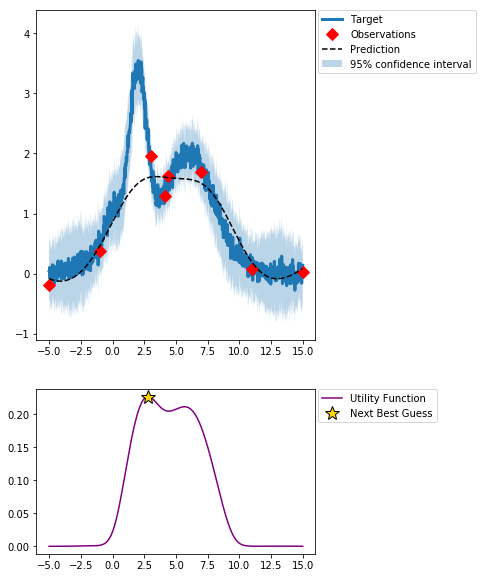

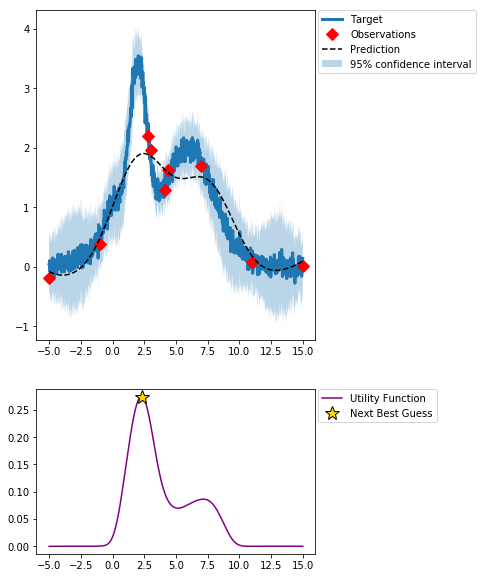

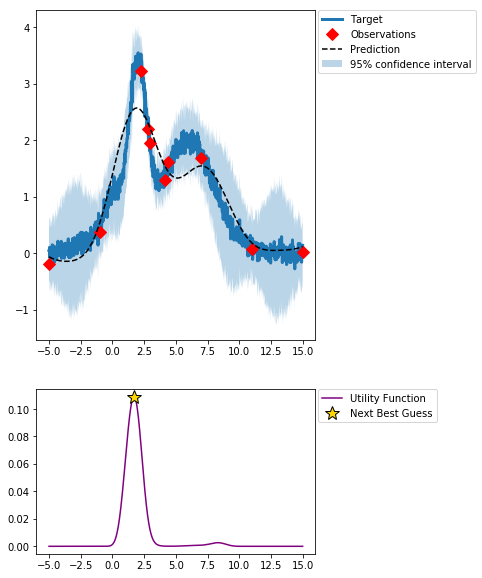

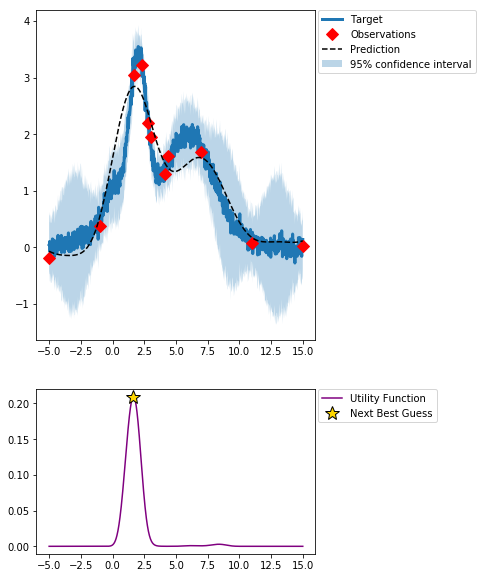

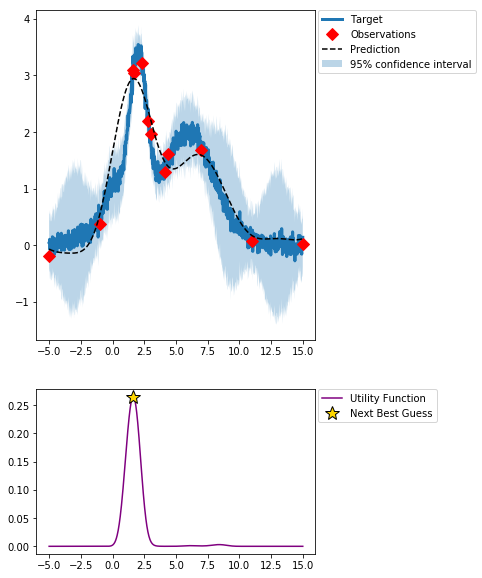

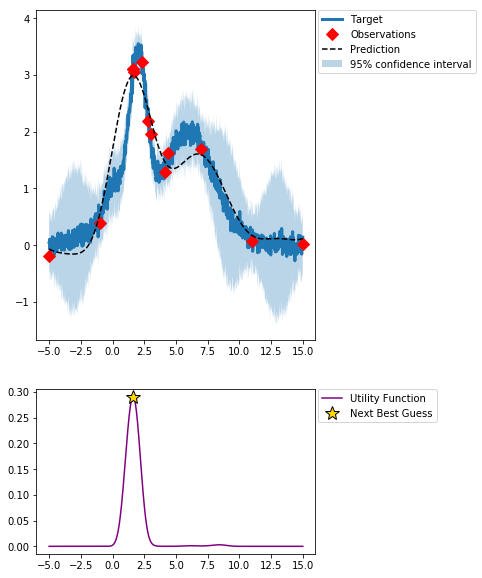

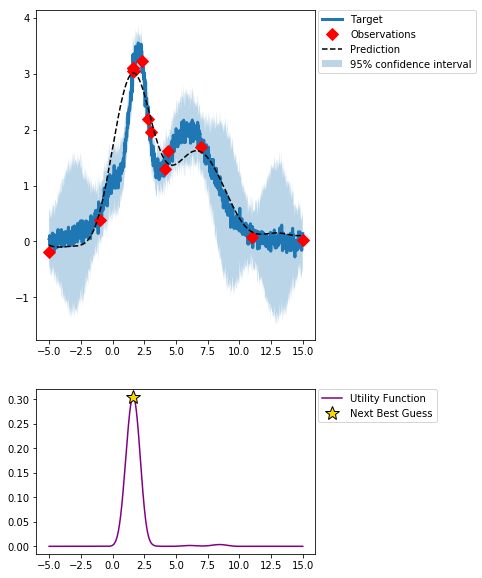

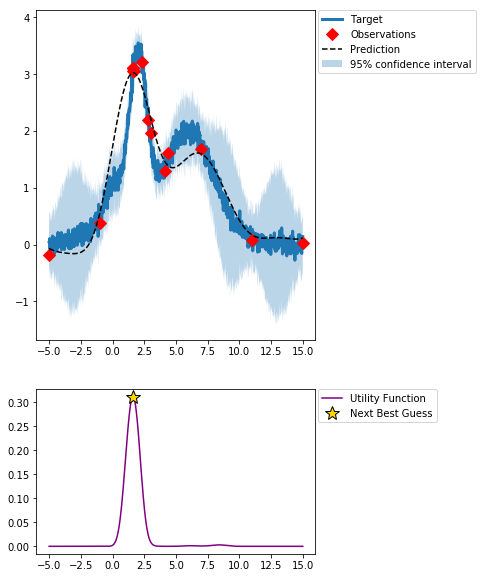

In [10]:
#
iteration = 10
for i in range(iteration):
    # initialize likelihood and model
    likelihood = GaussianLikelihood(log_noise_bounds=(-3, -1))
    model = ExactGPModel(train_x.data, train_y.data, likelihood)

    #train model
    train_model(model,train_x,train_y)
    observed_pred = eval_model(model,likelihood)
    #choose acquisition function 
    
    #acq,index = ucb(observed_pred)
    acq,index = ei(observed_pred,train_y)
    acq,index = poi(observed_pred,train_y)
    
    
    
    xx = Variable(x[index]).view(1)
    yy = target(xx)
    plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy(), observed_pred, True, acq, True)

    # append the next best guess into training set 
    train_x = torch.cat((train_x,xx))
    train_y = torch.cat((train_y,yy))


In [11]:
torch.cuda.current_device()

3